# Quality control - filtering and doublet removal

Goal: filter data to contain only true high quality cells

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import os
# import scrublet as scr
from wand.image import Image as WImage

In [5]:
os.makedirs('3_QC/', exist_ok=True)
sc.settings.autosave = True
sc.settings.set_figure_params(dpi=80)

Parameters

In [1]:
mito_percentage = snakemake.params.mito_percentage
number_genes_per_cell = snakemake.params.number_genes_per_cell
number_UMI_per_cell = snakemake.params.number_UMI_per_cell
sample = snakemake.wildcards.samples
mito_genes_csv = snakemake.input.mito_genes

figdir = f"3_QC/{sample}"
sc.settings.figdir = figdir

print(f"RUNNING SAMPLE: {sample}")
print(f"Filter by number of genes per cell: {number_genes_per_cell}")
print(f"Filter by number of UMI per cell: {number_UMI_per_cell}")
print(f"Filter by % mitochondrial genes: {mito_percentage}")

NameError: name 'snakemake' is not defined

# 1. Create an object with data from all samples

In [8]:
# Ambient RNA corrected data
adata = sc.read_10x_mtx(f"SoupX/{sample}")
adata.obs["sample"] = sample

# Filtered matrix from Cellranger Count
raw_data = sc.read_10x_mtx(f"{sample}/outs/filtered_feature_bc_matrix")
raw_data.obs["sample"] = sample
adata.raw = raw_data

### Print summary of dataset
Number of cells per sample before filtering

In [9]:
print(adata.obs['sample'].value_counts())

A    4627
Name: sample, dtype: int64


# 2. Calculate QC

Get mitochondrial genes for our species from Ensembl

In [30]:
mito_ensembl_ids = pd.read_csv(mito_genes_csv, index_col = 0)
adata.var['mt'] = adata.var_names.str.endswith(tuple(mito_ensembl_ids['ensembl_gene_id'])) 

FileNotFoundError: [Errno 2] No such file or directory: 'sscrofa_mito_genes.csv'

Calculate QC metrics - percentage of mitochondrial genes per cell and add to metadata

In [11]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

Scanpy's calculate_qc_metrics adds these fields to the data:
- n_genes_by_counts: number of genes wiht positive counts in a cell
- total_counts: total number of counts for a cell
- total_counts_mt: total number of mitochondrial counts
- pct_counts_mt: proportion ot total counts for a cell which are mitochondrial

Add fraction of counts in mitochondrial genes vs all genes (precent_mt2) and total counts per cell (n_counts)

In [12]:
mito_genes = adata.var_names.str.endswith(tuple(mito_ensembl_ids['ensembl_gene_id']))
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mt2'] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

## 2.1 Plot QC
Before any filtering

... storing 'sample' as categorical
... storing 'feature_types' as categorical


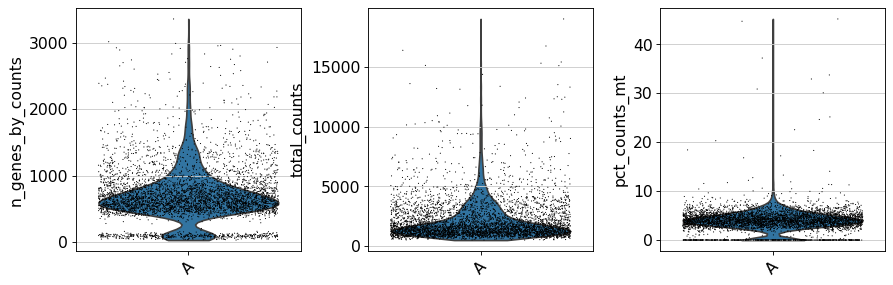

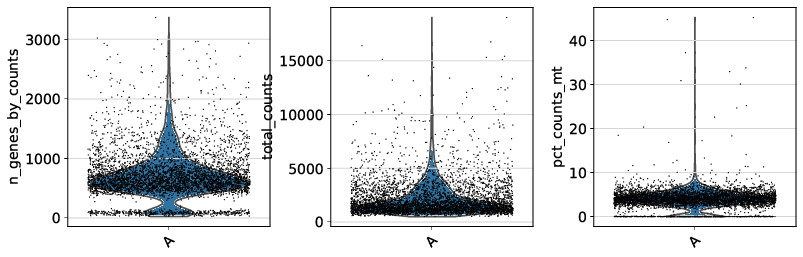

In [13]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, groupby = 'sample', rotation= 45,
            save = f"_{sample}_QC_before_filtering.pdf")

img = WImage(filename = f"{figdir}/violin_{sample}_QC_before_filtering.pdf")
img

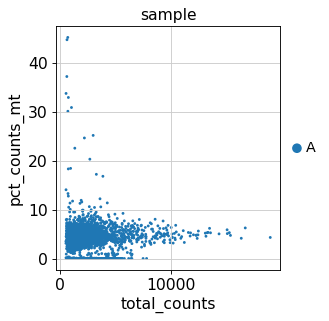

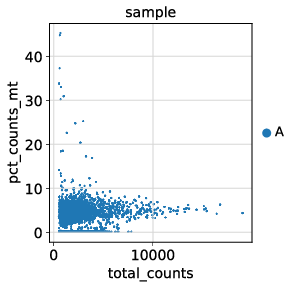

In [14]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', color="sample", 
              save = f"_{sample}_pct_counts_mt_vs_total_counts.pdf")
img = WImage(filename = f"{figdir}/scatter_{sample}_pct_counts_mt_vs_total_counts.pdf")
img

pct_counts_mt = proportion ot total counts for a cell which are mitochondrial  
total_counts = total number of counts for a cell

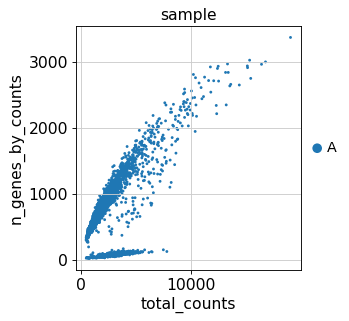

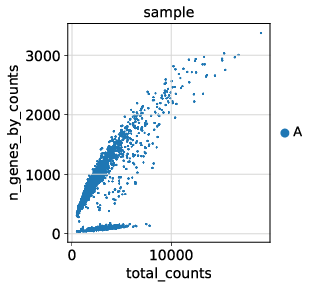

In [15]:
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color="sample", 
              save = f"_{sample}_ngenes_by_counts_vs_total_counts.pdf")

img = WImage(filename = f"{figdir}/scatter_{sample}_ngenes_by_counts_vs_total_counts.pdf")
img

n_genes_by_counts = number of genes with positive counts in a cell  
total_counts = total number of counts for a cell

# 3. Filtering

## 3.1 Filter cell outliers based on counts and numbers of genes expressed.

Keep cells with at least X number of genes per cell and minimum Y UMI counts per cell.  
This is to filter measurement outliers, i.e. “unreliable” observations.

In [16]:
print(f"Minimum genes per cell: {number_genes_per_cell}")
print(f"Minimum UMI counts per cell: {number_UMI_per_cell}")

Minimum genes per cell: 500
Minimum UMI counts per cell: 1000


In [17]:
print(f"Starting cells: {adata.n_obs}")
print(f"Starting genes: {adata.n_vars}")

sc.pp.filter_cells(adata, min_genes=number_genes_per_cell)
sc.pp.filter_cells(adata, min_counts=number_UMI_per_cell) 

print(f"Remaining cells: {adata.n_obs}")
print(f"Remaining genes: {adata.n_vars}")

Starting cells: 4627
Starting genes: 31908
Remaining cells: 3352
Remaining genes: 31908


In [18]:
sc.pp.filter_cells(adata, min_genes=number_genes_per_cell)
sc.pp.filter_cells(adata, min_counts=number_UMI_per_cell) 

print(f"Remaining cells: {adata.n_obs}")
print(f"Remaining genes: {adata.n_vars}")

Remaining cells: 3352
Remaining genes: 31908


#### Percentage of counts per gene:

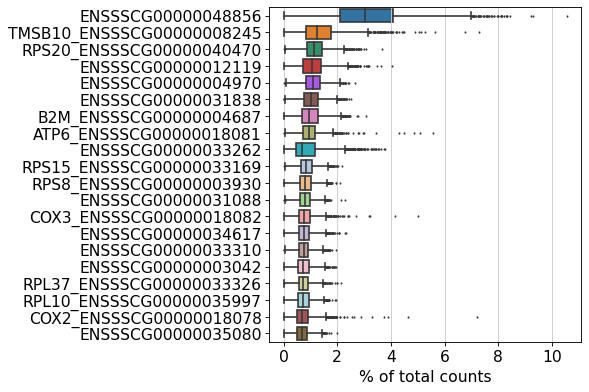

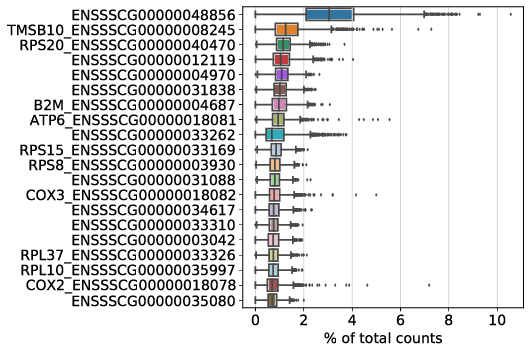

In [19]:
sc.pl.highest_expr_genes(adata, n_top=20, 
                         save = f"_{sample}.pdf")

img = WImage(filename = f"{figdir}/highest_expr_genes_{sample}.pdf")
img

## 3.2 Filter mitochondrial reads
Mitochondrial ratio: percentage of cell reads originating from mitochondrial genes

In [20]:
print(f"Starting cells: {adata.n_obs}")
adata = adata[adata.obs['pct_counts_mt'] < 10, :]

print(f"Remaining cells: {adata.n_obs}")

Starting cells: 3352
Remaining cells: 3337


## 4. Plot filtered QC

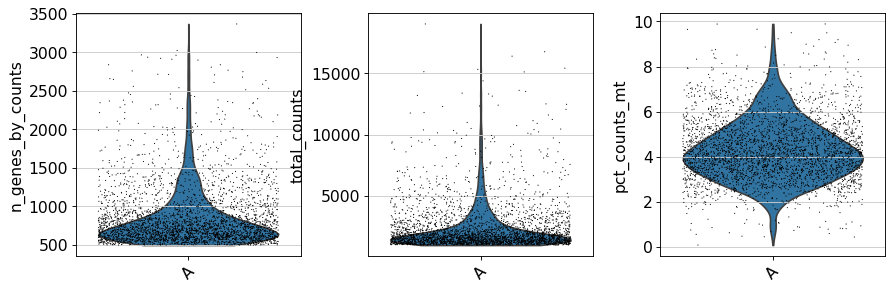

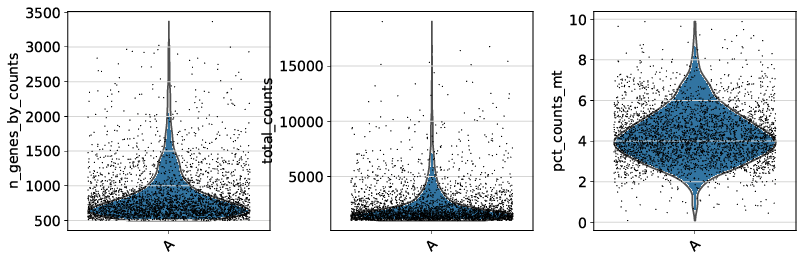

In [21]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, groupby = 'sample', rotation = 45,
            save = f"_{sample}_QC_after_filtering.pdf")

img = WImage(filename=f"{figdir}/violin_{sample}_QC_after_filtering.pdf")
img

## Save data

In [22]:
save_file = f'3_QC/{sample}_QC.h5ad'
adata.write_h5ad(save_file)

/home/WUR/moiti001/miniconda3/envs/single-cell-preprocessing-pipeline/lib/python3.6/site-packages/anndata/_core/anndata.py:1229: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
... storing 'feature_types' as categorical
